# Analyse de données : Projet

**Trinome :**

*Youssef AL AMRANI - M2 TIW*

*M.Kais EL HADJ MUSTAPHA  - M2 TIW*

*Yara NEFAA  - M2 TIW*

## Présentation du jeu de données

Le jeu de données choisi constitue une version élargie du jeu de données Goodbooks 10k, extrait à partir de l'API de la plateforme Goodreads. Le fichier books_enriched.csv intègre des champs additionnels. L'élément clé de cette nouvelle version réside dans l'inclusion d'un champ dédié à la description textuelle pour 9943 des 10 000 livres.

Nous avons optés pour cette version enrichie car elle comporte ainsi plusieurs opportunités diverses que ce soit en terme de nettoyage de données, d'exploitation de données, d'analyse, mais aussi de visualisation.

In [ ]:
! git clone https://github.com/malcolmosh/goodbooks-10k-extended.git

Cloning into 'goodbooks-10k-extended'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 102 (delta 20), reused 35 (delta 20), pack-reused 66
Receiving objects: 100% (102/102), 123.49 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (37/37), done.
Updating files: 100% (20/20), done.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Ouvrages

La structure des du fichier initial.

In [ ]:
df_books = pd.read_csv("/content/goodbooks-10k-extended/samples/books.csv")
df_books.T[0]

book_id                                                                      1
goodreads_book_id                                                      2767052
best_book_id                                                           2767052
work_id                                                                2792775
books_count                                                                272
isbn                                                                 439023483
isbn13                                                         9780439023480.0
authors                                                        Suzanne Collins
original_publication_year                                               2008.0
original_title                                                The Hunger Games
title                                  The Hunger Games (The Hunger Games, #1)
language_code                                                              eng
average_rating                                      

La structure des du fichier enrichi.

In [ ]:
df_books_enriched = pd.read_csv("/content/goodbooks-10k-extended/books_enriched.csv")
df_books_enriched.drop("Unnamed: 0", axis=1, inplace=True)
df_books_enriched.drop("index", axis=1, inplace=True)
df_books_enriched.T[0]

authors                                                    ['Suzanne Collins']
average_rating                                                            4.34
best_book_id                                                           2767052
book_id                                                                      1
books_count                                                                272
description                  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
genres                       ['young-adult', 'fiction', 'fantasy', 'science...
goodreads_book_id                                                      2767052
image_url                    https://images.gr-assets.com/books/1447303603m...
isbn                                                                 439023483
isbn13                                                         9780439023480.0
language_code                                                              eng
original_publication_year                           

On affiche les types des colonnes du dataframe.

In [ ]:
df_books_enriched.dtypes

authors                       object
average_rating               float64
best_book_id                   int64
book_id                        int64
books_count                    int64
description                   object
genres                        object
goodreads_book_id              int64
image_url                     object
isbn                          object
isbn13                       float64
language_code                 object
original_publication_year    float64
original_title                object
pages                        float64
publishDate                   object
ratings_1                      int64
ratings_2                      int64
ratings_3                      int64
ratings_4                      int64
ratings_5                      int64
ratings_count                  int64
small_image_url               object
title                         object
work_id                        int64
work_ratings_count             int64
work_text_reviews_count        int64
a

###Pages & Année de publication

On remplace les valeurs NaN des pages et on converti la colonne en valeurs entières.

In [ ]:
df_books_enriched['pages'].fillna(0, inplace=True)
df_books_enriched['pages'] = df_books_enriched['pages'].astype(int)

In [ ]:
df_books_enriched['pages']

0       374
1       309
2       501
3       324
4       200
       ... 
9995    816
9996    436
9997    368
9998    362
9999    475
Name: pages, Length: 10000, dtype: int64

On remplaces les valeurs NaN des années et on convertit la colonne en valeurs entières. On exclut par la suite les valeurs nulles (0).

In [ ]:
df_books_enriched['original_publication_year'].fillna(0, inplace=True)
df_books_enriched['original_publication_year'] = df_books_enriched['original_publication_year'].astype(int)

In [ ]:
df_books_enriched = df_books_enriched[df_books_enriched['original_publication_year'] != 0]
df_books_enriched['original_publication_year']

0       2008
1       1997
2       2005
3       1960
4       1925
        ... 
9995    2005
9996    2016
9997    2000
9998    2010
9999    1998
Name: original_publication_year, Length: 10000, dtype: int64

### Titres

Supprimons les ouvrages dupliqués.

In [ ]:
df_books_enriched['goodreads_book_id'].duplicated().sum()

0

In [ ]:
df_books_enriched['best_book_id'].duplicated().sum()

0

In [ ]:
df_books_enriched['title'].duplicated().sum()

36

In [ ]:
duplicates = df_books_enriched.loc[(df_books_enriched['title'].duplicated(keep=False))==True,:].sort_values('title')
duplicates.head(5)

authors  average_rating  best_book_id  \
319                        ['Stephen King']            3.99         11590   
1210  ['Stephen King', 'Jerry N. Uelsmann']            4.25          5413   
3825                       ['Jenő Barcsay']            3.97        327246   
8713                    ['[Sarah Simblet]']            3.97        327242   
5689                       ['Tom Stoppard']            4.19        384597   

      book_id  books_count                                        description  \
319       349          211  Thousands of miles away from the small townshi...   
1210     1292           22  Stephen King's second novel, the vampire bests...   
3825     4186           14  It’s the classic in its field—a reference work...   
8713     5268            5  For millennia, the human body has been celebra...   
5689     6481           24  Arcadia takes us back and forth between the ni...   

                                                 genres  goodreads_book_id  \
319   ['horror', 'fiction', 'fantasy', 'thriller', '...              11590   
1210  ['horror', 'fiction', 'fantasy', 'paranormal',...               5413   
3825  ['art', 'nonfiction', 'graphic-novels', 'class...             327246   
8713          ['art', 'nonfiction', 'books', 'science']             327242   
5689      ['fiction', 'classics', 'historical-fiction']             384597   

                                              image_url        isbn  ...  \
319   https://images.gr-assets.com/books/1327891565m...   450031063  ...   
1210  https://images.gr-assets.com/books/1320478491m...   385516487  ...   
3825  https://images.gr-assets.com/books/1328858785m...  1402735421  ...   
8713  https://images.gr-assets.com/books/1309295064m...  078948045X  ...   
5689  https://images.gr-assets.com/books/1463617930m...   571169341  ...   

      ratings_3 ratings_4  ratings_5 ratings_count  \
319       57171     89196      85556        228680   
1210      12040     24920      35451         72797   
3825       4389      5692       9293         21640   
8713       3413      3978       7637         17000   
5689       2408      4948       7789         15362   

                                        small_image_url  \
319   https://images.gr-assets.com/books/1327891565s...   
1210  https://images.gr-assets.com/books/1320478491s...   
3825  https://images.gr-assets.com/books/1328858785s...   
8713  https://images.gr-assets.com/books/1309295064s...   
5689  https://images.gr-assets.com/books/1463617930s...   

                       title   work_id  work_ratings_count  \
319             'Salem's Lot   3048937              246360   
1210            'Salem's Lot  40802405               74725   
3825  Anatomy for the Artist    317884               21688   
8713  Anatomy for the Artist    317880               17050   
5689                 Arcadia   1303332               16149   

      work_text_reviews_count                              authors_2  
319                      6167                       ['Stephen King']  
1210                      482  ['Stephen King', 'Jerry N. Uelsmann']  
3825                       24                       ['Jenő Barcsay']  
8713                       49                    ['[Sarah Simblet]']  
5689                      749                       ['Tom Stoppard']  

[5 rows x 28 columns]

In [ ]:
df_books_enriched = df_books_enriched.drop_duplicates(subset = ['title'])
df_books_enriched = df_books_enriched.reset_index(drop = True)

### Auteurs

Mise en forme des colonnes authors et authors_2.

In [ ]:
df_books_enriched['authors'][1]

"['J.K. Rowling', 'Mary GrandPré']"

In [ ]:
len(eval(df_books_enriched['authors'][1]))

2

In [ ]:
def authors_names(df, column) :
  result = []
  for i in range(len(df)) :
    result.append(eval(df[column][i]))
  return result

def nb_authors_count(df, column) :
  result = []
  for i in range(len(df)) :
    try :
      result.append(len(df[column][i]))
    except :
      result.append(-1)
  return result

In [ ]:
df_books_enriched['authors'] = authors_names(df_books_enriched, 'authors')
df_books_enriched['authors_2'] = authors_names(df_books_enriched, 'authors_2')
df_books_enriched.head()

authors  average_rating  best_book_id  book_id  \
0              [Suzanne Collins]            4.34       2767052        1   
1  [J.K. Rowling, Mary GrandPré]            4.44             3        2   
2              [Stephenie Meyer]            3.57         41865        3   
3                   [Harper Lee]            4.25          2657        4   
4          [F. Scott Fitzgerald]            3.89          4671        5   

   books_count                                        description  \
0          272  WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...   
1          491  Harry Potter's life is miserable. His parents ...   
2          226  About three things I was absolutely positive.\...   
3          487  The unforgettable novel of a childhood in a sl...   
4         1356  Alternate Cover Edition ISBN: 0743273567 (ISBN...   

                                              genres  goodreads_book_id  \
0  ['young-adult', 'fiction', 'fantasy', 'science...            2767052   
1  ['fantasy', 'fiction', 'young-adult', 'classics']                  3   
2  ['young-adult', 'fantasy', 'romance', 'fiction...              41865   
3  ['classics', 'fiction', 'historical-fiction', ...               2657   
4  ['classics', 'fiction', 'historical-fiction', ...               4671   

                                           image_url       isbn  ...  \
0  https://images.gr-assets.com/books/1447303603m...  439023483  ...   
1  https://images.gr-assets.com/books/1474154022m...  439554934  ...   
2  https://images.gr-assets.com/books/1361039443m...  316015849  ...   
3  https://images.gr-assets.com/books/1361975680m...   61120081  ...   
4  https://images.gr-assets.com/books/1490528560m...  743273567  ...   

   ratings_3 ratings_4  ratings_5 ratings_count  \
0     560092   1481305    2706317       4780653   
1     455024   1156318    3011543       4602479   
2     793319    875073    1355439       3866839   
3     446835   1001952    1714267       3198671   
4     606158    936012     947718       2683664   

                                     small_image_url  \
0  https://images.gr-assets.com/books/1447303603s...   
1  https://images.gr-assets.com/books/1474154022s...   
2  https://images.gr-assets.com/books/1361039443s...   
3  https://images.gr-assets.com/books/1361975680s...   
4  https://images.gr-assets.com/books/1490528560s...   

                                               title  work_id  \
0            The Hunger Games (The Hunger Games, #1)  2792775   
1  Harry Potter and the Sorcerer's Stone (Harry P...  4640799   
2                            Twilight (Twilight, #1)  3212258   
3                              To Kill a Mockingbird  3275794   
4                                   The Great Gatsby   245494   

   work_ratings_count  work_text_reviews_count                      authors_2  
0             4942365                   155254              [Suzanne Collins]  
1             4800065                    75867  [J.K. Rowling, Mary GrandPré]  
2             3916824                    95009              [Stephenie Meyer]  
3             3340896                    72586                   [Harper Lee]  
4             2773745                    51992          [F. Scott Fitzgerald]  

[5 rows x 28 columns]

Comparaison des colonnes 'authors' et 'authors_2'

In [ ]:
authors_count = nb_authors_count(df_books_enriched, 'authors')
authors_2_count = nb_authors_count(df_books_enriched, 'authors_2')
pd.DataFrame(authors_count).value_counts() == pd.DataFrame(authors_2_count).value_counts()

1     True
2     True
3     True
4     True
5     True
6     True
14    True
8     True
10    True
15    True
7     True
17    True
9     True
11    True
29    True
22    True
24    True
12    True
21    True
19    True
16    True
47    True
dtype: bool

In [ ]:
df_books_enriched['authors_count'] = authors_count
df_books_enriched = df_books_enriched[df_books_enriched['authors_count'] != -1]
df_books_enriched = df_books_enriched.drop('authors_2', axis = 1)
df_books_enriched = df_books_enriched.reset_index(drop=True)

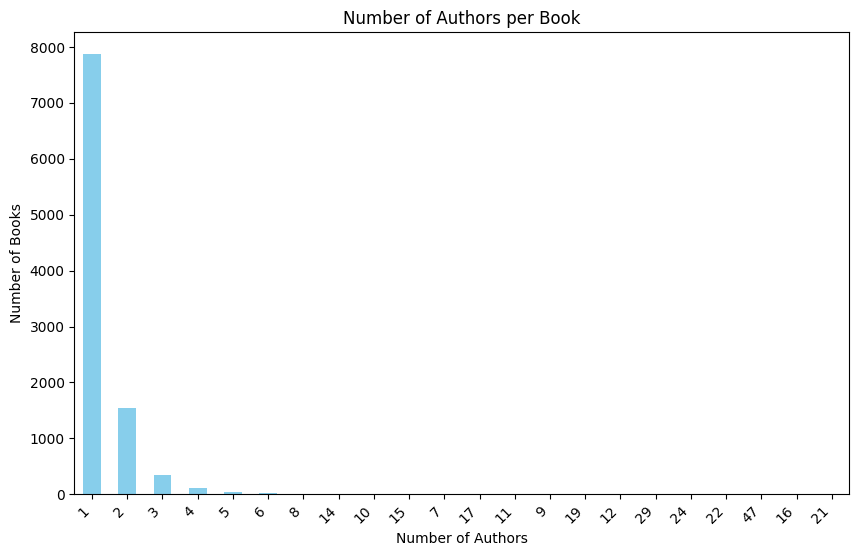

In [ ]:
plt.figure(figsize=(10, 6))
df_books_enriched['authors_count'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Authors per Book')
plt.xlabel('Number of Authors')
plt.ylabel('Number of Books')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
authors = [j for i in df_books_enriched['authors'] for j in i]
all_authors = list(set(authors))
author_counts = pd.Series(authors).value_counts()

print('Number of authors : ' + str(len(all_authors)))

Number of authors : 6471


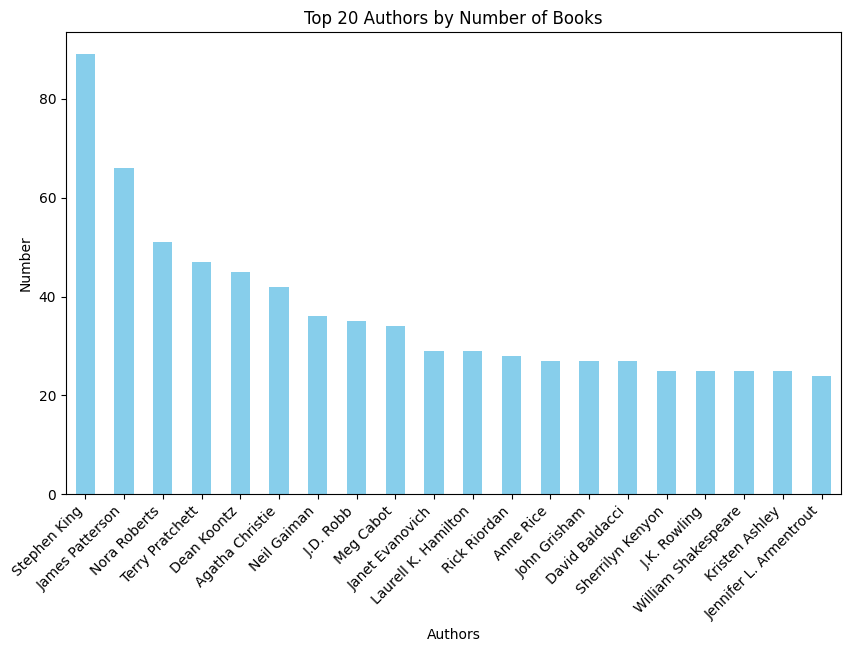

In [ ]:
plt.figure(figsize=(10, 6))
author_counts[0:20].plot(kind='bar', color='skyblue')
plt.title('Top 20 Authors by Number of Books')
plt.xlabel('Authors')
plt.ylabel('Number')
plt.xticks(rotation=45, ha='right')
plt.show()

### Langues

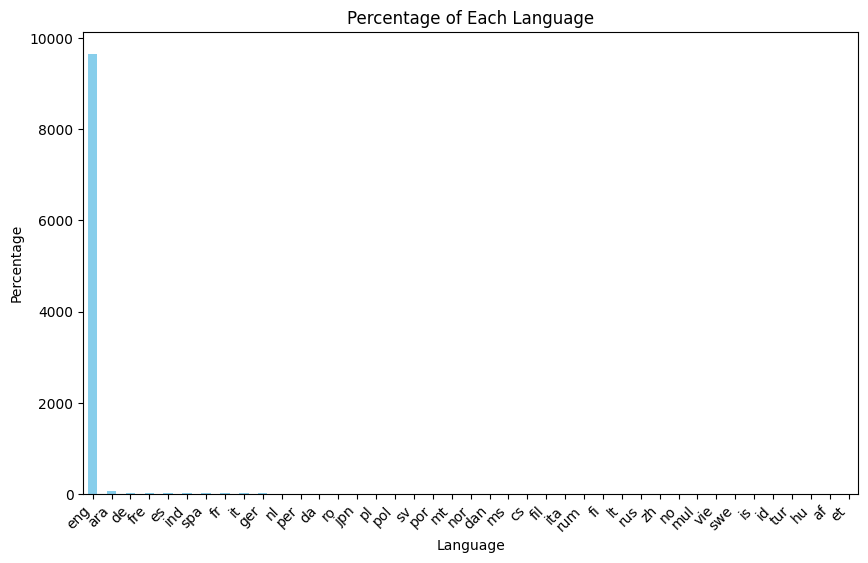

In [ ]:
plt.figure(figsize=(10, 6))
df_books_enriched["language_code"].value_counts().plot(kind='bar', color='skyblue')
plt.title('Percentage of Each Language')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.show()

On ne gardera ainsi que les ouvrages de langue anglaise, le nombre des autres langues étant marginal.

In [ ]:
df_books_enriched = df_books_enriched.drop(df_books_enriched[df_books_enriched["language_code"] != "eng"].index)
df_books_enriched = df_books_enriched.reset_index(drop = True)

### Genres

Mise en forme des genres des ouvrages.

In [ ]:
eval(df_books_enriched['genres'][574])

['young-adult', 'fiction', 'classics', 'contemporary']

In [ ]:
genres = [j for i in df_books_enriched['genres'] for j in eval(i)]
all_genres = list(set(genres))
genre_counts = pd.Series(genres).value_counts(normalize=True) * 100

print('Number of genres : ' + str(len(all_genres)))

Number of genres : 39


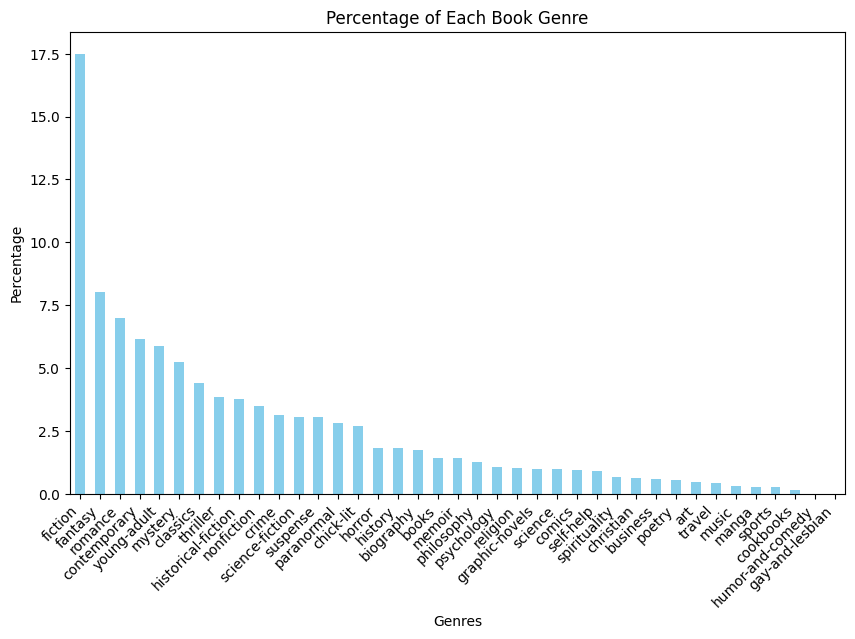

In [ ]:
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Percentage of Each Book Genre')
plt.xlabel('Genres')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
df_books_enriched = df_books_enriched.drop(columns=['best_book_id',	'work_id', 'language_code', 'ratings_count', 'isbn', 'isbn13', 'work_text_reviews_count', 'small_image_url'])
df_books_enriched = df_books_enriched.reset_index(drop=True)

### Description

Nettoyage des descriptions des ouvrages et ajout d'un champ supplémentaires pour les description sans stopwords et sans ponctuations.

In [ ]:
df_books_enriched["description"][5024]

nan

In [ ]:
error = []

for i in range (len(df_books_enriched)):
  try :
    a = len(df_books_enriched["description"][i])
  except :
    error.append(i)

print(error[0:20])

[427, 905, 1037, 1234, 1242, 1549, 1561, 1619, 2466, 3109, 3170, 3439, 3864, 4417, 5024, 5125, 5193, 5285, 5382, 5505]


In [ ]:
df_books_enriched = df_books_enriched[df_books_enriched['description'].apply(lambda x: type(x) != float)]
df_books_enriched = df_books_enriched.reset_index(drop=True)

In [ ]:
def desc_cleaning(text, tokenizer, stopwords):

    text = str(text).lower()

    text = re.sub(r"\[(.*?)\]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\w+…|…", "", text)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", " ", text
    )
    text = re.sub(r"\s+", " ", text)

    tokens = tokenizer(text)
    tokens = [t for t in tokens if not t in stopwords]
    tokens = ["" if t.isdigit() else t for t in tokens]
    tokens = [t for t in tokens if len(t) > 1]
    tokens = ' '.join(tokens)

    return tokens

tokenizer = word_tokenize
stop_words = set(stopwords.words("english"))

df_books_enriched["desc_tokens"] = df_books_enriched["description"].map(lambda x: desc_cleaning(x, word_tokenize, stop_words))

In [ ]:
print(df_books_enriched["description"][0])
print(df_books_enriched["desc_tokens"][0])

WINNING MEANS FAME AND FORTUNE.LOSING MEANS CERTAIN DEATH.THE HUNGER GAMES HAVE BEGUN. . . .In the ruins of a place once known as North America lies the nation of Panem, a shining Capitol surrounded by twelve outlying districts. The Capitol is harsh and cruel and keeps the districts in line by forcing them all to send one boy and once girl between the ages of twelve and eighteen to participate in the annual Hunger Games, a fight to the death on live TV.Sixteen-year-old Katniss Everdeen regards it as a death sentence when she steps forward to take her sister's place in the Games. But Katniss has been close to dead before—and survival, for her, is second nature. Without really meaning to, she becomes a contender. But if she is to win, she will have to start making choices that weight survival against humanity and life against love.
winning means fame fortune losing means certain death hunger games begun ruins place known north america lies nation panem shining capitol surrounded twelve o

### Embeddings de Description

Exraction des embeddings de textes à partir des descriptions des ouvrages.

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=bf1e354c1a4742d77643a4d0221768b22cacc8728bc9e9d13e3dffd4c4832b94
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [ ]:
embeddings = []

for i in tqdm(range(len(df_books_enriched))) :
  embeddings.append(model.encode(df_books_enriched['desc_tokens'][i], convert_to_tensor=False))

100%|██████████| 9593/9593 [11:49<00:00, 13.53it/s]


In [ ]:
embeddings[765]

array([-4.79216278e-02,  4.03896812e-03,  2.55463682e-02, -1.40901387e-03,
        5.11329621e-02,  5.40785231e-02, -4.93019708e-02, -7.38912299e-02,
        5.55729754e-02, -3.70416827e-02,  3.70890647e-02,  1.20958854e-02,
       -7.09566548e-02,  1.09612783e-02, -4.00999514e-03,  4.25424203e-02,
       -3.52218747e-02,  6.66550500e-03, -5.99292852e-02,  1.17370738e-02,
       -3.40176933e-02, -4.60273959e-03, -6.89635566e-03,  6.94027767e-02,
       -4.71940972e-02,  2.91592553e-02,  2.66686678e-02, -6.86077401e-02,
       -4.30310443e-02,  3.91553640e-02,  5.79139739e-02,  9.35385674e-02,
       -1.11658834e-01, -1.38938092e-02,  2.31407378e-02,  2.72725355e-02,
       -3.12273260e-02,  1.93012916e-02, -5.55967633e-03,  1.60872657e-02,
       -2.68297158e-02, -2.62261461e-02, -2.24194396e-02,  5.93592301e-02,
       -5.39397169e-03, -9.84561518e-02, -7.14304100e-04, -3.92147303e-02,
       -1.60328690e-02, -4.28514667e-02,  3.43643464e-02, -2.63664685e-02,
       -1.15578532e-01, -

In [ ]:
df_books_enriched['desc_embeddings'] = embeddings

Calcul de la similarité en cosinus entre les descriptions de deux ouvrages.

In [ ]:
cosine_scores = util.cos_sim(embeddings[765], embeddings[654])

print(cosine_scores[0][0])

tensor(0.2865)


On cherche par la suite à représenter graphiquement ces embeddings en 2D, ainsi qu'à déterminer des clusters à l'aide de DBSCAN, d'où le recours à de la réduction de dimension.

In [ ]:
pca = PCA(n_components=2)
result = pca.fit_transform(embeddings)

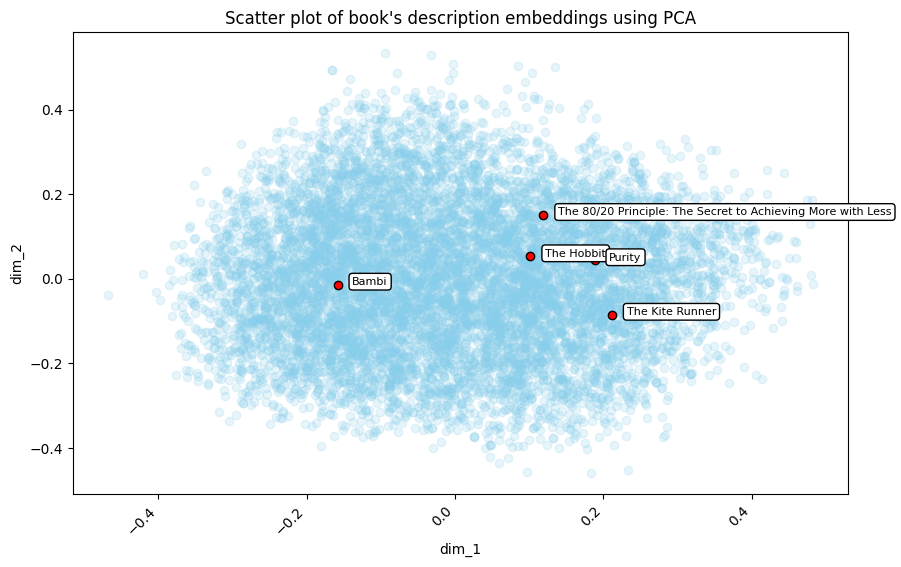

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(result[:, 0], result[:, 1], color='skyblue', alpha=.2)
plt.title("Scatter plot of book's description embeddings using PCA")
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.xticks(rotation=45, ha='right')

selected = [10, 6, 3090, 2794, 5492]

words = [df_books_enriched['title'][i] for i in selected]
for i in selected :
    plt.annotate(df_books_enriched['title'][i], xy=(result[i, 0] + 0.02, result[i, 1]), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'), fontsize=8)
    plt.scatter(result[i, 0], result[i, 1], color='red', edgecolor='black', linewidth=1)
plt.show()

La PCA ne semble pas suffisante pour nos données.

In [ ]:
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')

In [ ]:
embeddings2d = tsne.fit_transform(np.array(embeddings))

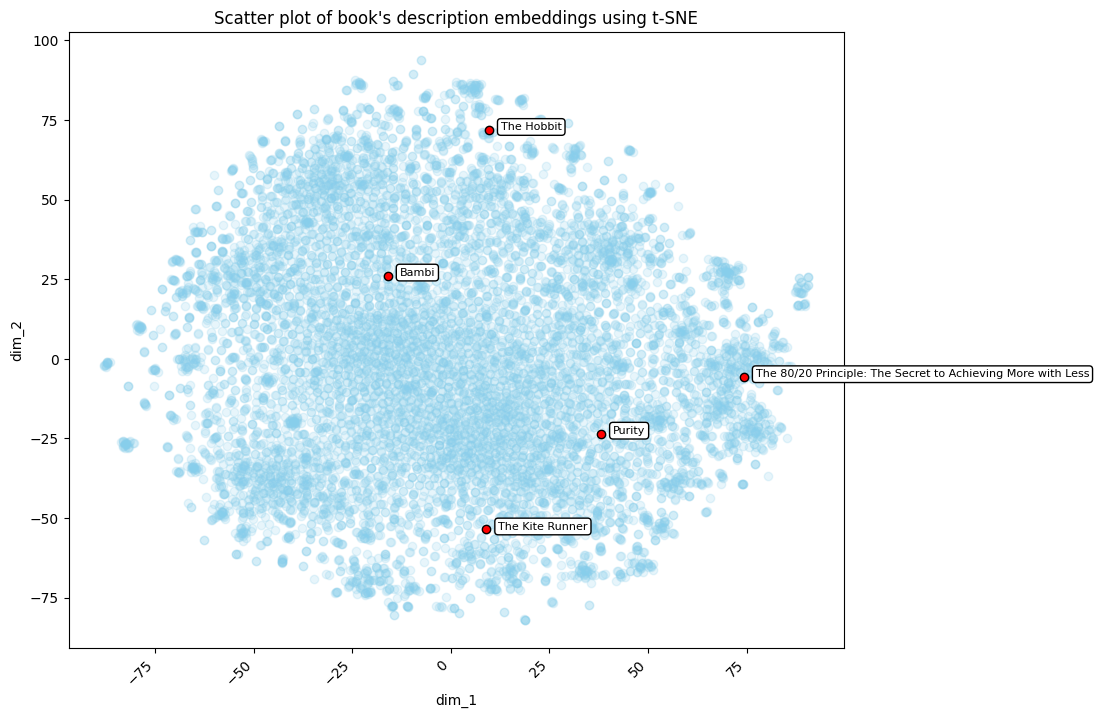

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(embeddings2d[:,0], embeddings2d[:,1], color='skyblue', alpha=0.2)
plt.title("Scatter plot of book's description embeddings using t-SNE")
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.xticks(rotation=45, ha='right')

selected = [10, 6, 3090, 2794, 5492]

words = [df_books_enriched['title'][i] for i in selected]
for i in selected :
    plt.annotate(df_books_enriched['title'][i], xy=(embeddings2d[i, 0] + 3, embeddings2d[i, 1]), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'), fontsize=8)
    ax.scatter(embeddings2d[i,0], embeddings2d[i, 1], color='red', edgecolor='black', linewidth=1)
plt.show()

t-SNE est ainsi beacoup plus approprié.

In [ ]:
df_books_enriched['desc_embeddings_x'] = embeddings2d[:,0]
df_books_enriched['desc_embeddings_y'] = embeddings2d[:,1]

### Embeddings de Première de Couverture (Image)

Il s'agira maintenant d'extraire les embeddings à partic des première de couverture de chaque ouvrage.

In [ ]:
list(df_books_enriched['image_url'])[0]

'https://images.gr-assets.com/books/1447303603m/2767052.jpg'

In [ ]:
!mkdir images
print('Done.')

Done.


In [ ]:
def download_image(url, output_folder='images'):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            filename = os.path.join(output_folder, os.path.basename(url))
            with open(filename, 'wb') as f:
                f.write(response.content)
        else:
            print(f"Failed to download image from {url}. Status code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading image from {url}: {e}")

for i in tqdm(range(len(df_books_enriched))):
    download_image(df_books_enriched['image_url'][i], '/content/images')

 38%|███▊      | 3640/9593 [20:20<65:46:00, 39.77s/it]

Error downloading image from https://images.gr-assets.com/books/1277997811m/161887.jpg: HTTPSConnectionPool(host='images.gr-assets.com', port=443): Max retries exceeded with url: /books/1277997811m/161887.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f1df98963e0>, 'Connection to images.gr-assets.com timed out. (connect timeout=None)'))


 76%|███████▌  | 7311/9593 [40:20<25:10:48, 39.72s/it]

Error downloading image from https://images.gr-assets.com/books/1349538226m/15768536.jpg: HTTPSConnectionPool(host='images.gr-assets.com', port=443): Max retries exceeded with url: /books/1349538226m/15768536.jpg (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7f1df9895090>, 'Connection to images.gr-assets.com timed out. (connect timeout=None)'))


100%|██████████| 9593/9593 [51:54<00:00,  3.08it/s]


In [ ]:
print(len(os.listdir('/content/images/')))

6410


Le téléchargement d'image n'a pu être possible que pour 6410 ouvrages.

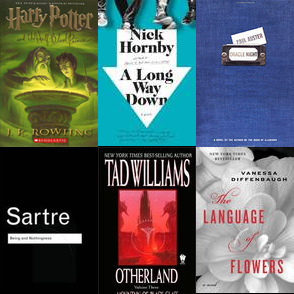

In [ ]:
def image_grid(imgs, cols):
    rows = (len(imgs) + cols - 1) // cols
    w = imgs[0].size[0]
    h = imgs[0].size[1]
    grid = Image.new('RGB', size=(cols*w, rows*h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_paths = [
    '/content/images/1.jpg',
    '/content/images/10073.jpg',
    '/content/images/10006.jpg',
    '/content/images/10033.jpg',
    '/content/images/10090.jpg',
    '/content/images/10032672.jpg'
    ]
images = []
for path in image_paths:
    images.append(Image.open(path))

grid = image_grid(images, cols=3)
display(grid)

In [ ]:
print(Image.open('/content/images/1.jpg').size)

(98, 147)


In [ ]:
resnet_model = models.resnet50(pretrained=True)
resnet_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

On adopte le preprocessing de nos images aux caractéristiques de Resnet50.

In [ ]:
preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [ ]:
def image_embeddings(img_path, model, preprocess):
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(img)
    img_tensor = img_tensor.unsqueeze(0)
    with torch.no_grad():
        embeddings = model(img_tensor)
    return embeddings

In [ ]:
embeddings = []
directory = os.listdir('/content/images/')
images_paths = ['/content/images/' + str(directory[i]) for i in range (len(directory))]

for i in tqdm(range(len(directory))) :
  embeddings.append(image_embeddings(images_paths[i], resnet_model, preprocess))

100%|██████████| 6410/6410 [24:49<00:00,  4.30it/s]


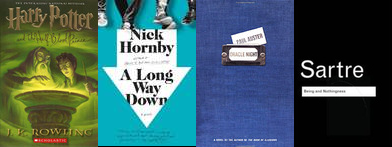

In [ ]:
image_paths = [
    '/content/images/1.jpg',
    '/content/images/10073.jpg',
    '/content/images/10006.jpg',
    '/content/images/10033.jpg'
    ]
images = []
for path in image_paths:
    images.append(Image.open(path))

grid = image_grid(images, cols=4)
display(grid)

On peut maintenant calculer la similarité en consinus pour la première page de couverture des ouvrages.

In [ ]:
image_vec_1 = image_embeddings('/content/images/1.jpg', resnet_model, preprocess)
image_vec_2 = image_embeddings('/content/images/10073.jpg', resnet_model, preprocess)
image_vec_3 = image_embeddings('/content/images/10006.jpg', resnet_model, preprocess)
image_vec_4 = image_embeddings('/content/images/10033.jpg', resnet_model, preprocess)

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim_1 = cos(image_vec_1, image_vec_2)
cos_sim_2 = cos(image_vec_1, image_vec_3)
cos_sim_3 = cos(image_vec_1, image_vec_4)

print('\nCosine similarity 1 & 2: {0}\n'.format(cos_sim_1))
print('\nCosine similarity 1 & 3: {0}\n'.format(cos_sim_2))
print('\nCosine similarity 1 & 4: {0}\n'.format(cos_sim_3))


Cosine similarity 1 & 2: tensor([0.5184])


Cosine similarity 1 & 3: tensor([0.4429])


Cosine similarity 1 & 4: tensor([0.6483])



In [ ]:
tsne = TSNE(random_state = 0, n_iter = 1000, metric = 'cosine')

In [ ]:
embeddingsnp = [t.flatten().numpy() for t in embeddings]
embeddings2d = tsne.fit_transform(np.array(embeddingsnp))

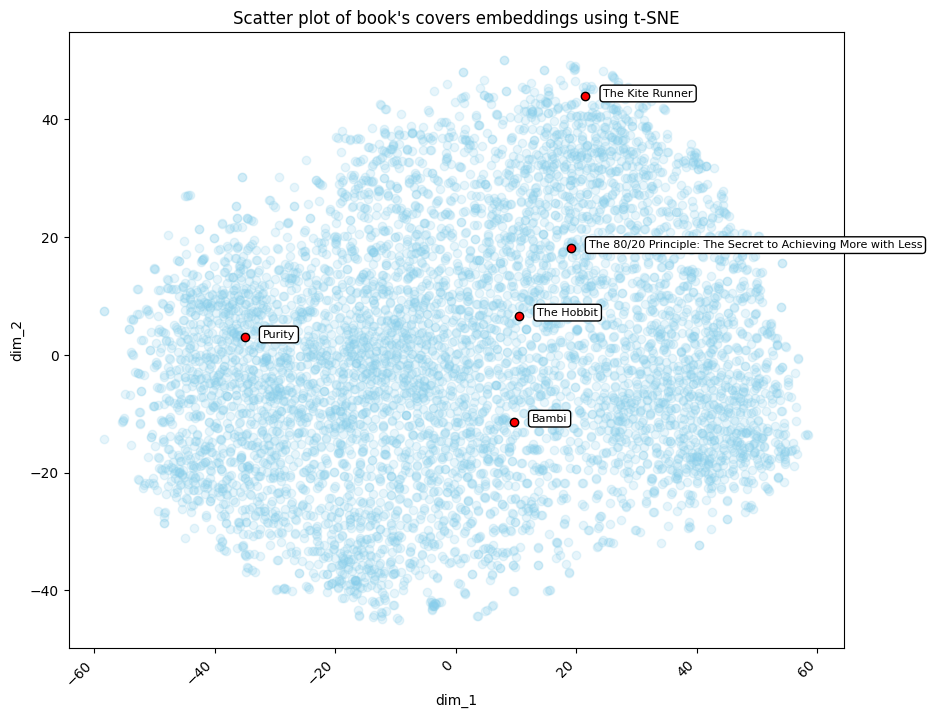

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(embeddings2d[:,0], embeddings2d[:,1], color='skyblue', alpha=0.2)
plt.title("Scatter plot of book's covers embeddings using t-SNE")
plt.xlabel('dim_1')
plt.ylabel('dim_2')
plt.xticks(rotation=45, ha='right')

selected = [10, 6, 3090, 2794, 5492]

words = [df_books_enriched['title'][i] for i in selected]
for i in selected :
    plt.annotate(df_books_enriched['title'][i], xy=(embeddings2d[i, 0] + 3, embeddings2d[i, 1]), bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'), fontsize=8)
    ax.scatter(embeddings2d[i,0], embeddings2d[i, 1], color='red', edgecolor='black', linewidth=1)
plt.show()

In [ ]:
directory = [i.split('.')[0] for i in directory]
df_img_emb = pd.DataFrame({'goodreads_book_id': directory, 'img_embeddings': embeddingsnp, 'img_embeddings_x' : embeddings2d[:,0], 'img_embeddings_y' : embeddings2d[:,1]})
df_img_emb.head()

goodreads_book_id                                     img_embeddings  \
0           8369681  [-2.4635336, -0.67660445, -1.251843, -2.525596...   
1          18652002  [-1.4745616, -1.5150374, -2.5006013, -3.573628...   
2          17349023  [-0.7676177, 0.17593081, 0.1077951, 1.6312268,...   
3           9266776  [1.6181011, -0.9397675, -2.5700033, -3.402491,...   
4             10913  [-0.4857635, 1.4042366, -0.9420836, -2.8068757...   

   img_embeddings_x  img_embeddings_y  
0         49.825260         -2.901026  
1          6.080452        -42.598782  
2        -15.706486         29.231279  
3         51.598507        -17.557695  
4         40.666058         -8.340613

In [ ]:
for i in range(len(df_img_emb)) :
  try :
    df_img_emb['goodreads_book_id'][i] = int(df_img_emb['goodreads_book_id'][i])
  except :
    df_img_emb = df_img_emb.drop(i)

<ipython-input-69-0012abcead03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_img_emb['goodreads_book_id'][i] = int(df_img_emb['goodreads_book_id'][i])
<ipython-input-69-0012abcead03>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_img_emb['goodreads_book_id'][i] = int(df_img_emb['goodreads_book_id'][i])


In [ ]:
df_result = pd.merge(df_img_emb, df_books_enriched, on='goodreads_book_id', how='inner')
df_result.head()

goodreads_book_id                                     img_embeddings  \
0           8369681  [-2.4635336, -0.67660445, -1.251843, -2.525596...   
1          18652002  [-1.4745616, -1.5150374, -2.5006013, -3.573628...   
2          17349023  [-0.7676177, 0.17593081, 0.1077951, 1.6312268,...   
3           9266776  [1.6181011, -0.9397675, -2.5700033, -3.402491,...   
4             10913  [-0.4857635, 1.4042366, -0.9420836, -2.8068757...   

   img_embeddings_x  img_embeddings_y              authors  average_rating  \
0         49.825260         -2.901026  [Elizabeth Eulberg]            3.82   
1          6.080452        -42.598782     [[Laline Paull]]            3.67   
2        -15.706486         29.231279         [Wally Lamb]            3.79   
3         51.598507        -17.557695    [Claire LaZebnik]            3.73   
4         40.666058         -8.340613       [Jodi Picoult]            3.79   

   book_id  books_count                                        description  \
0     8780           10  It is a truth universally acknowledged, that a...   
1     5230           44  The Handmaid's Tale meets The Hunger Games in ...   
2     2281           27  In middle age, Annie Oh—wife, mother, and outs...   
3     4655            5  At Coral Tree Prep in Los Angeles, who your pa...   
4     1426           50  “A triumph. This novel’s haunting strength wil...   

                                              genres  ... ratings_3  \
0  ['young-adult', 'romance', 'contemporary', 'ch...  ...      4502   
1  ['fiction', 'fantasy', 'science-fiction', 'con...  ...      5561   
2                        ['fiction', 'contemporary']  ...     10538   
3  ['young-adult', 'romance', 'contemporary', 'ch...  ...      8930   
4  ['fiction', 'contemporary', 'chick-lit', 'reli...  ...     19883   

   ratings_4 ratings_5               title work_ratings_count  authors_count  \
0       5182      5361  Prom and Prejudice              16771              1   
1       7521      5015            The Bees              20906              1   
2      17625     10489        We Are Water              42626              1   
3       9261      8537           Epic Fail              30179              1   
4      26392     17348       Keeping Faith              69258              1   

                                         desc_tokens  \
0  truth universally acknowledged single girl hig...   
1  handmaid tale meets hunger games brilliantly i...   
2  middle age annie oh—wife mother outsider artis...   
3  coral tree prep los angeles parents make break...   
4  triumph novel haunting strength hold reader en...   

                                     desc_embeddings  desc_embeddings_x  \
0  [-0.0465852, -0.0036380882, 0.07595185, 0.0160...          -4.250494   
1  [0.044652347, -0.09224607, 0.037274934, 0.0170...           8.061397   
2  [-0.015417464, -0.054783992, 0.04929762, 0.029...          13.416105   
3  [-0.024829116, -0.03924827, 0.104829475, -0.00...         -10.858683   
4  [0.02623122, 0.0032946828, 0.022789849, 0.0830...          70.545090   

   desc_embeddings_y  
0          10.812357  
1         -50.253063  
2         -18.966917  
3           9.080088  
4         -18.955721  

[5 rows x 27 columns]

On sauvegarde nos données au format CSV pour pouvoir les exploiter par la suite lors de l'étape de restitution (application DASH).

In [ ]:
df_result.to_csv('PROJECT_DA_books.csv', encoding='utf-8')

##Notes des utilisateurs

Passons maintenant aux données concernant les notes attribuées aux différents ouvrages par les utilisateurs de la plateforme.

In [ ]:
!pip install python-louvain

In [ ]:
df_ratings = pd.read_csv("/content/goodbooks-10k-extended/ratings.csv")
df_ratings['user_id'] = df_ratings['user_id'].apply(lambda x: 'u_' + str(x))
df_ratings

user_id  book_id  rating
0            u_1      258       5
1            u_2     4081       4
2            u_2      260       5
3            u_2     9296       5
4            u_2     2318       3
...          ...      ...     ...
5976474  u_49925      510       5
5976475  u_49925      528       4
5976476  u_49925      722       4
5976477  u_49925      949       5
5976478  u_49925     1023       4

[5976479 rows x 3 columns]

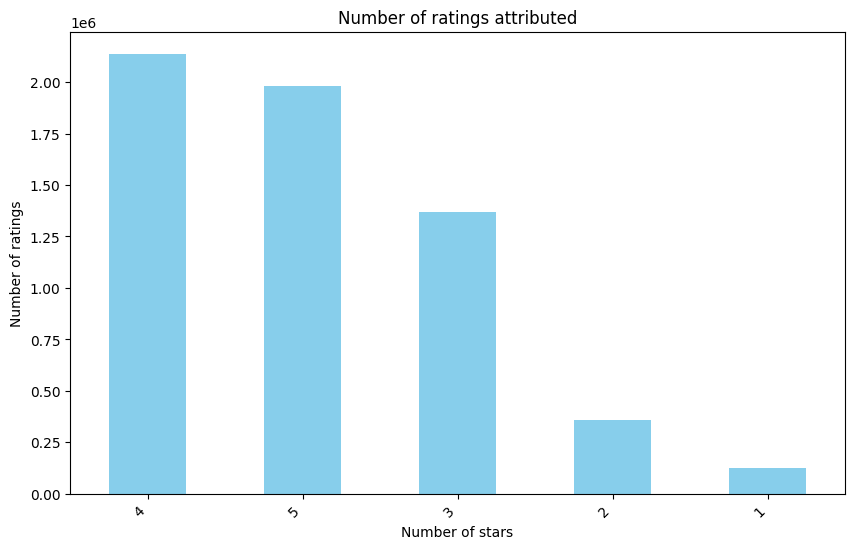

In [ ]:
plt.figure(figsize=(10, 6))
df_ratings['rating'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of ratings attributed')
plt.xlabel('Number of stars')
plt.ylabel('Number of ratings')
plt.xticks(rotation=45, ha='right')
plt.show()

On établit une jointure entre les id des ouvrages et leurs titres.

In [ ]:
books_rated_counts = df_ratings['book_id'].value_counts()
books_titles = [df_books_enriched['title'][i - 1] for i in list(books_rated_counts.index)]
books_rated_counts.index = books_titles
books_rated_counts

The Hunger Games (The Hunger Games, #1)                     22806
Harry Potter and the Sorcerer's Stone (Harry Potter, #1)    21850
To Kill a Mockingbird                                       19088
Twilight (Twilight, #1)                                     16931
The Great Gatsby                                            16604
                                                            ...  
Second Life                                                    36
A Year in Provence                                             33
The Life List                                                  24
Where You Are (Between the Lines, #2)                          11
Too Good to Be True                                             8
Name: book_id, Length: 10000, dtype: int64

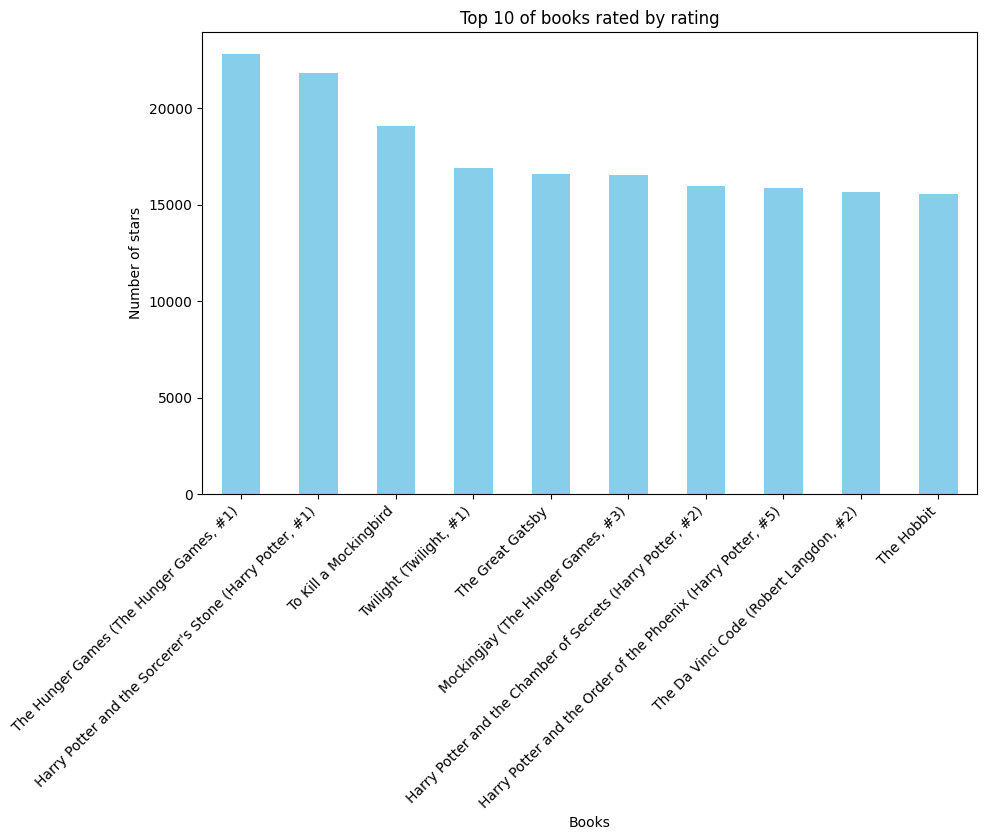

In [ ]:
plt.figure(figsize=(10, 6))
books_rated_counts[0:10].plot(kind='bar', color='skyblue')
plt.title('Top 10 of books rated by rating')
plt.xlabel('Books')
plt.ylabel('Number of stars')
plt.xticks(rotation=45, ha='right')
plt.show()

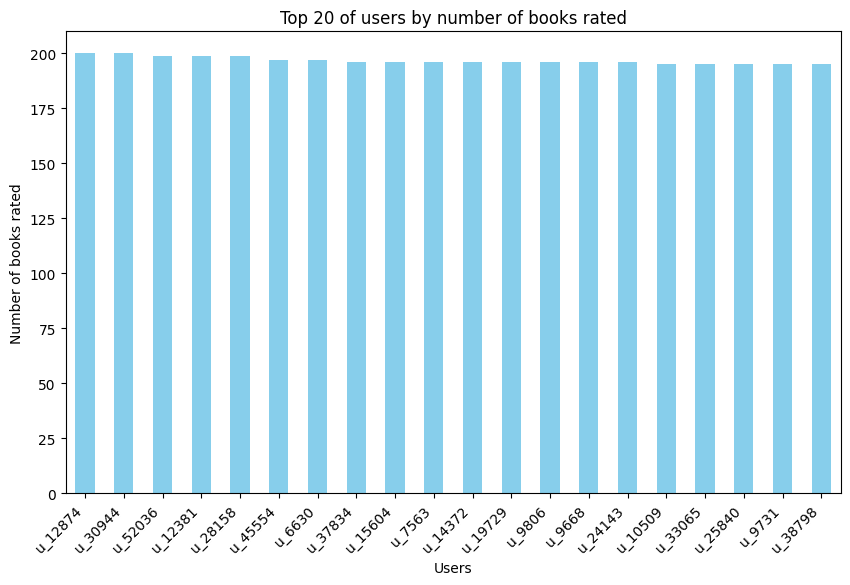

In [ ]:
plt.figure(figsize=(10, 6))
df_ratings['user_id'].value_counts()[0:20].plot(kind='bar', color='skyblue')
plt.title('Top 20 of users by number of books rated')
plt.xlabel('Users')
plt.ylabel('Number of books rated')
plt.xticks(rotation=45, ha='right')
plt.show()

Nous nous contenterons que de 200 lignes pour des raisons de performance et de clarté (visualisation).

In [ ]:
df_ratings = df_ratings[0:200]
df_ratings

user_id  book_id  rating
0       u_1      258       5
1       u_2     4081       4
2       u_2      260       5
3       u_2     9296       5
4       u_2     2318       3
..      ...      ...     ...
195    u_15       13       4
196    u_15       33       5
197    u_15       26       3
198    u_15     2903       4
199    u_15      230       4

[200 rows x 3 columns]

Représentation des notes des utilisateurs pour les différents ouvrage (échelle de couleur pour les notes 1-5).

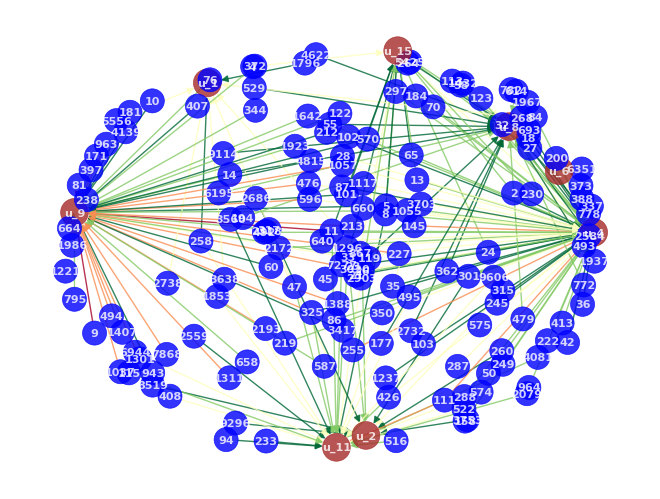

In [ ]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

G = nx.from_pandas_edgelist(df_ratings, source='book_id', target='user_id', edge_attr='rating', create_using=nx.DiGraph())

min_rating = min(df_ratings['rating'])
max_rating = max(df_ratings['rating'])
rescaled_ratings = [(rating - min_rating) / (max_rating - min_rating) for rating in df_ratings['rating']]

edge_ratings = {(book_id, user_id): rating for book_id, user_id, rating in zip(df_ratings['book_id'], df_ratings['user_id'], rescaled_ratings)}
edge_colors = [mcolors.to_rgba(plt.cm.RdYlGn(edge_ratings[edge]), alpha=0.7) for edge in G.edges]

color_map = []
for node in G:
    if node in list(df_ratings['book_id']):
        color_map.append('blue')
    elif node in list(df_ratings['user_id']):
        color_map.append('brown')
    else:
      color_map.append('black')

size_map = []
for node in G:
    if node in list(df_ratings['user_id']):
        size_map.append(400)
    else:
        size_map.append(300)

pos = nx.spring_layout(G, k=1, iterations=100)

nx.draw(G, pos, node_color=color_map, node_size=size_map, with_labels=True, font_size=8, font_color="white", font_weight="bold", edge_color=edge_colors, linewidths=0.5, alpha=0.8)
plt.show()

Clustering à l'aide de l'algorithme de Louvain.

<ipython-input-198-225fb820e828>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


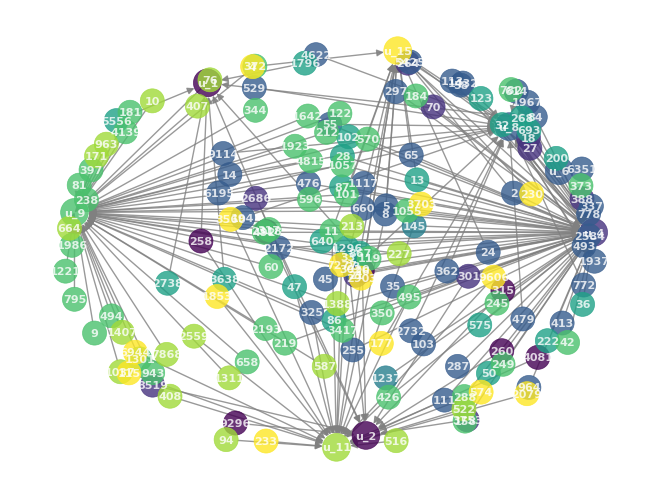

In [ ]:
partition = {node: community_id for community_id, community in enumerate(nx.community.louvain_communities(G, seed=123)) for node in community}
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw(G, pos, node_color=list(partition.values()), cmap=cmap, node_size=size_map, with_labels=True, font_size=8, font_color="white", font_weight="bold", edge_color='grey', linewidths=0.5, alpha=0.8)
plt.show()

Le calcul de mesures spécifiques aux graphes (degré, centralité) et leurs visualisation sera implémenté lors de l'étape de restitution (application DASH).

## Tags des ouvrages

On s'interresse ici aux différents tags attribués par les utilisateurs. Cette partie n'a malheuresement pas été aussi aboutie que l'on avait espéré.

In [ ]:
from wordcloud import WordCloud

In [ ]:
df_tags = pd.read_csv("/content/goodbooks-10k-extended/tags.csv")
df_tags

tag_id    tag_name
0           0           -
1           1        --1-
2           2       --10-
3           3       --12-
4           4      --122-
...       ...         ...
34247   34247   Ｃhildrens
34248   34248   Ｆａｖｏｒｉｔｅｓ
34249   34249       Ｍａｎｇａ
34250   34250      ＳＥＲＩＥＳ
34251   34251  ｆａｖｏｕｒｉｔｅｓ

[34252 rows x 2 columns]

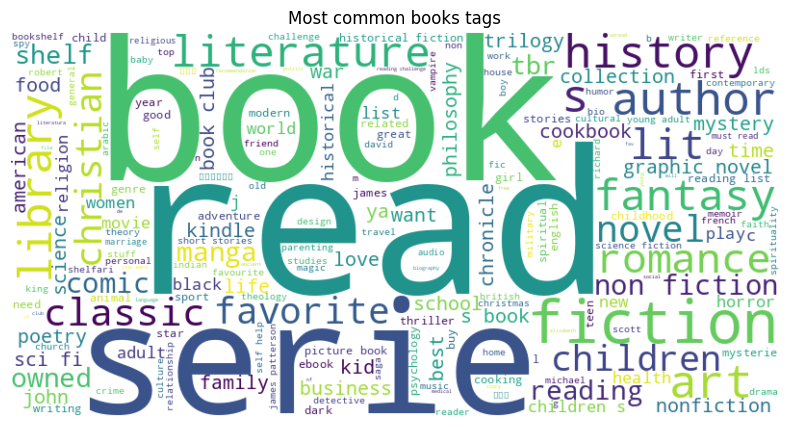

In [ ]:
text = ' '.join(df_tags['tag_name'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most common books tags')
plt.show()

## Ouvrages à lire

Finalement, nous avon aussi étudié les différents ouvrages sauvegardés par les utilisateurs avec la mention 'à lire'.

In [ ]:
import networkx as nx
import matplotlib.colors as mcolors

In [ ]:
df_to_read = pd.read_csv("/content/goodbooks-10k-extended/to_read.csv")
df_to_read['user_id'] = df_to_read['user_id'].apply(lambda x: 'u_' + str(x))
df_to_read

user_id  book_id
0           u_9        8
1          u_15      398
2          u_15      275
3          u_37     7173
4          u_34      380
...         ...      ...
912700  u_39374     1049
912701  u_10492     5180
912702  u_21879     4827
912703  u_21879     6642
912704  u_48192     7773

[912705 rows x 2 columns]

In [ ]:
df_books_enriched = pd.read_csv("/content/goodbooks-10k-extended/books_enriched.csv")
df_books_enriched['book_id']

0           1
1           2
2           3
3           4
4           5
        ...  
9995     9981
9996     9982
9997     9985
9998     9987
9999    10000
Name: book_id, Length: 10000, dtype: int64

On établit une jointure entre les id des ouvrages et leurs titres.

In [ ]:
books_to_read_counts = df_to_read['book_id'].value_counts()
books_titles = [df_books_enriched['title'][i - 1] for i in list(books_to_read_counts.index)]
books_to_read_counts.index = books_titles
books_to_read_counts

Eragon (The Inheritance Cycle, #1)                            2772
Green Eggs and Ham                                            1967
Hamlet                                                        1840
The Diary of a Young Girl                                     1812
The Kite Runner                                               1767
                                                              ... 
The War that Saved My Life (The War That Saved My Life #1)       1
The Upanishads: Translations from the Sanskrit                   1
A Trick of the Light (Chief Inspector Armand Gamache, #7)        1
Cold Vengeance (Pendergast, #11)                                 1
Fables, Vol. 6: Homelands                                        1
Name: book_id, Length: 9986, dtype: int64

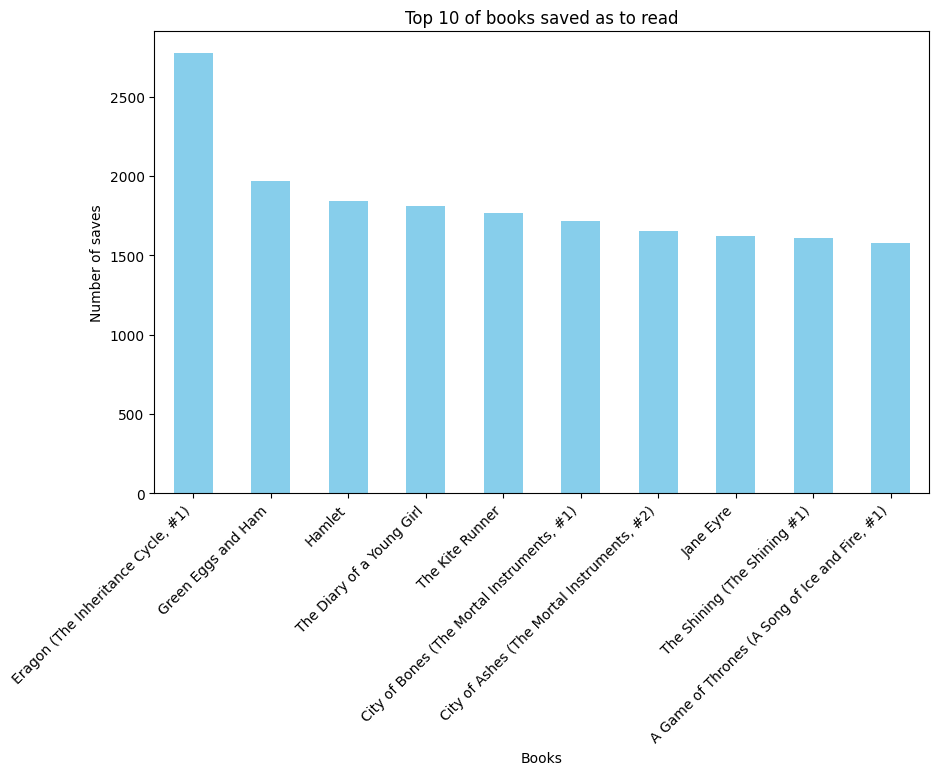

In [ ]:
plt.figure(figsize=(10, 6))
books_to_read_counts[0:10].plot(kind='bar', color='skyblue')
plt.title('Top 10 of books saved as to read')
plt.xlabel('Books')
plt.ylabel('Number of saves')
plt.xticks(rotation=45, ha='right')
plt.show()

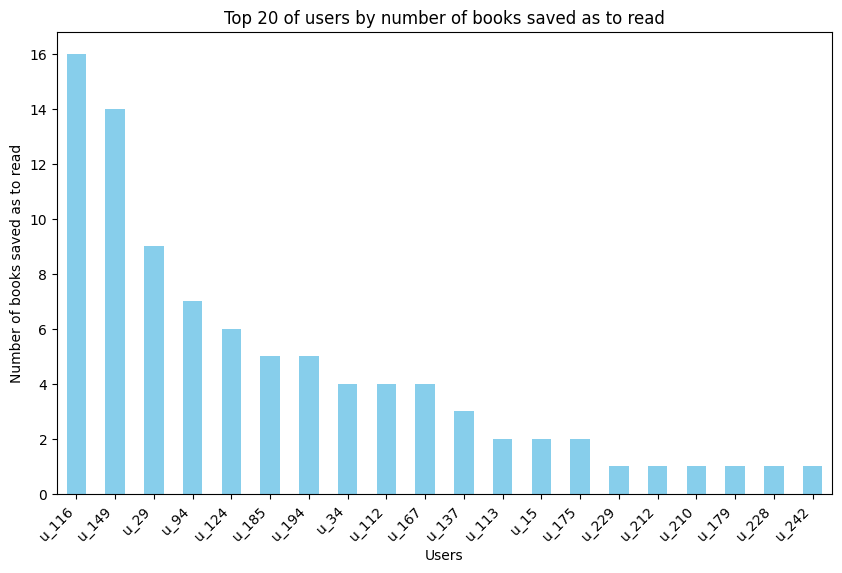

In [ ]:
plt.figure(figsize=(10, 6))
df_to_read['user_id'].value_counts()[0:20].plot(kind='bar', color='skyblue')
plt.title('Top 20 of users by number of books saved as to read')
plt.xlabel('Users')
plt.ylabel('Number of books saved as to read')
plt.xticks(rotation=45, ha='right')
plt.show()

Nous nous contentons une fois encore des 200 premières lignes.

In [ ]:
df_to_read = df_to_read[0:200]
df_to_read

<ipython-input-238-a57ae6cc311f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_read['user_id'] = df_to_read['user_id'].apply(lambda x: 'u_' + str(x))


user_id  book_id
0       u_9        8
1      u_15      398
2      u_15      275
3      u_37     7173
4      u_34      380
..      ...      ...
195   u_453     1238
196   u_453     7251
197   u_322     9759
198   u_322     9927
199   u_245        8

[200 rows x 2 columns]

On représente le réseaux des ouvrages 'à lire' ainsi que les utilisateurs.

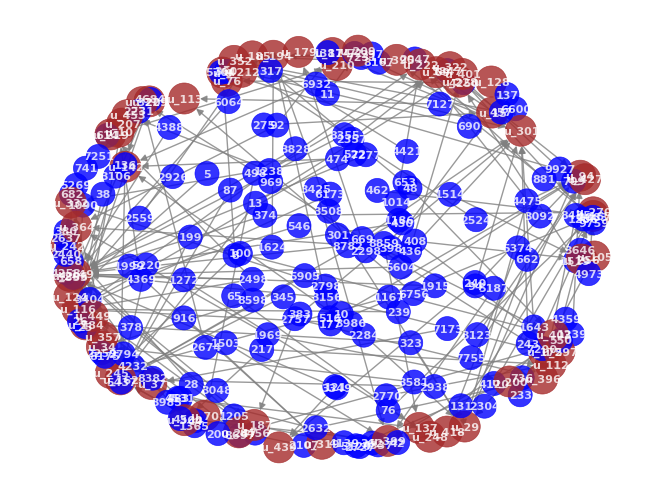

In [ ]:
G = nx.from_pandas_edgelist(df_to_read, target='user_id', source='book_id', create_using=nx.DiGraph())

color_map = []
for node in G:
    if node in list(df_to_read['book_id']):
        color_map.append('blue')
    elif node in list(df_to_read['user_id']):
        color_map.append('brown')
    else:
      color_map.append('black')

size_map = []
for node in G:
    if node in list(df_to_read['user_id']):
        size_map.append(500)
    elif node in list(df_to_read['book_id']):
        size_map.append(300)
    else:
        size_map.append(300)

pos = nx.spring_layout(G, k=1, iterations=100)

nx.draw(G, pos, node_color=color_map, node_size=size_map, with_labels=True, font_size=8, font_color="white", font_weight="bold", edge_color='grey', linewidths=0.5, alpha=0.8)
plt.show()

Clustering à l'aide de l'algorithme de Louvain.

<ipython-input-240-225fb820e828>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)


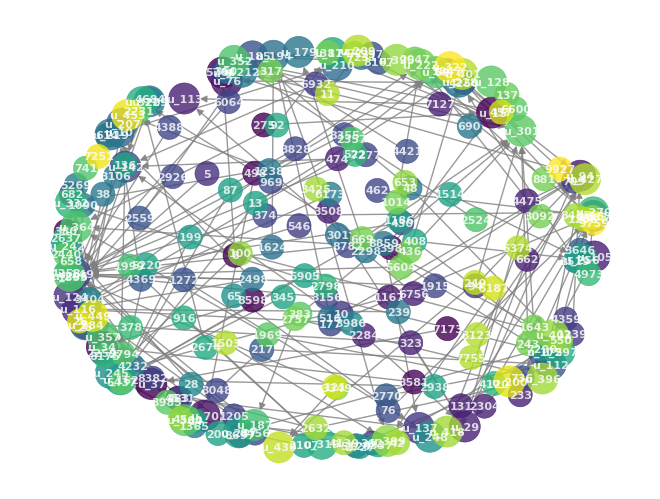

In [ ]:
partition = {node: community_id for community_id, community in enumerate(nx.community.louvain_communities(G, seed=123)) for node in community}
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw(G, pos, node_color=list(partition.values()), cmap=cmap, node_size=size_map, with_labels=True, font_size=8, font_color="white", font_weight="bold", edge_color='grey', linewidths=0.5, alpha=0.8)
plt.show()

fin.